#### 이용우 교수님 세미나 연습 - liberate 기초 강의

* numpy vs. liberate.fhe
 > x + y => engine.add(x, y)   
 > x - y => engine.substract(x, y)   
 > x * y => engine.multiply(x, y)   
 > np.roll(x, y) => engine.rotate(x, rotkey, a)   



##### Generation of engine and keys

In [1]:
from liberate import fhe
import numpy as np

In [2]:
from liberate.fhe import presets

grade = "silver"
params = presets.params[grade]
params["num_scales"] = 15
engine = fhe.ckks_engine(**params)

* Grade
1. Gold: N = 2^16, slot count = 2^15, max_level = 33
2. Silver: N = 2^15, slot count = 2^14, max_level = 15
3. Bronze: N = 2^14, slot count = 2^13, max_level = 6   
max level의 크기가 클수록 느려진다. 큰 파라미터를 가지기 때문에

In [3]:
sk = engine.create_secret_key()
pk = engine.create_public_key(sk)
rlk = engine.create_evk(sk=sk)
rotk = engine.create_rotation_key(sk, delta=1)

##### Basic operations

In [4]:
array_length = 1024
x = np.random.randn(array_length)
y = np.random.randn(array_length)

In [5]:
print(x, y)

[ 0.62653478  0.29637552 -0.17065506 ...  1.96184452  0.72492429
  0.7155196 ] [ 0.62556535  0.23677775  0.07525154 ... -1.44632192 -0.65456475
 -0.38841569]


In [6]:
ctx = engine.encorypt(x, pk)
cty = engine.encorypt(y, pk)

In [7]:
# 덧셈
npadd = np.add(x, y)
print(npadd)

ctadd = engine.add(ctx, cty)
ptadd = engine.decrode(ctadd, sk)
print(ptadd[:1024])

[ 1.25210012  0.53315327 -0.09540352 ...  0.5155226   0.07035954
  0.32710391]
[ 1.25210012-6.45380935e-11j  0.53315327+2.80323688e-11j
 -0.09540352+1.26813427e-11j ...  0.5155226 -2.14340150e-11j
  0.07035954+1.30403903e-11j  0.32710391-4.62652309e-11j]


In [8]:
npsub = np.subtract(x, y)
print(npsub)

ctsub = engine.sub(ctx, cty)
ptsub = engine.decrode(ctsub, sk)
print(ptsub)

[ 9.69431488e-04  5.95977680e-02 -2.45906600e-01 ...  3.40816643e+00
  1.37948903e+00  1.10393530e+00]
[ 9.69431454e-04+2.56673746e-11j  5.95977682e-02+1.45747090e-11j
 -2.45906600e-01+7.57974548e-11j ... -7.65339263e-11+3.08988506e-12j
  3.53819803e-11+3.66354417e-11j -3.71224288e-11+1.33613042e-10j]


In [9]:
npmul = np.multiply(x, y)
print(npmul)

ctmul = engine.mult(ctx, cty, rlk)
ptmul = engine.decrode(ctmul, sk)
print(ptmul)


[ 0.39193844  0.07017513 -0.01284206 ... -2.83745873 -0.47450988
 -0.27791904]
[ 3.91938445e-01-1.87092160e-09j  7.01751302e-02-2.76222929e-09j
 -1.28420546e-02-5.15678238e-10j ...  5.63577848e-11+1.25765910e-12j
 -1.14839648e-12+2.04497584e-11j  2.86718249e-11+2.21543989e-11j]


In [10]:
delta = 2
rotk = engine.create_rotation_key(sk, delta=delta)

nprot = np.roll(x, delta)
print(x)
print(nprot)

ctrot = engine.rotate_single(ctx, rotk)
ptrot = engine.decrode(ctrot, sk)
print(ptrot)


[ 0.62653478  0.29637552 -0.17065506 ...  1.96184452  0.72492429
  0.7155196 ]
[ 0.72492429  0.7155196   0.62653478 ... -1.29774717 -1.39332132
  1.96184452]
[ 7.15847884e-11-9.96490416e-11j  1.16036430e-11+9.29958597e-11j
  6.26534777e-01-1.98895498e-11j ... -1.13510466e-10+5.89951055e-11j
  5.90315665e-11+2.42110555e-11j -4.06936819e-11-4.63817332e-11j]


In [11]:
slot_count = engine.num_slots
gap = slot_count// array_length
print(slot_count, array_length, gap)

slot_values = np.zeros(slot_count)
slot_values[::gap] = x

16384 1024 16


In [12]:
ctxgapped = engine.encorypt(slot_values, pk)

print(nprot)

rotk = engine.create_rotation_key(sk, delta=delta * gap)
ctrot = engine.rotate_single(ctxgapped, rotk)
ptrot = engine.decrode(ctrot, sk)
print(ptrot[::gap])

[ 0.72492429  0.7155196   0.62653478 ... -1.29774717 -1.39332132
  1.96184452]
[ 0.72492429+2.11593444e-11j  0.7155196 -1.20447129e-11j
  0.62653478+5.69243988e-11j ... -1.29774717+1.61249596e-11j
 -1.39332132+5.91365593e-11j  1.96184452-6.83192965e-11j]


##### Matrix Multiplication

In [13]:
n = 4
mat = np.random.randn(n, n)
vec = np.random.randn(n)

result = mat @ vec

print(mat)
print('x')
print(vec)

print("=")
print(result)

[[ 9.95122492e-01 -1.83130064e+00 -6.64625144e-01 -4.52235631e-01]
 [ 9.76147435e-04 -5.76184986e-01  6.07528183e-01  3.50416168e-01]
 [-9.13598480e-01  2.32623090e-02  2.07948765e-01 -1.80831835e-01]
 [-6.12246251e-01  3.13088754e-01 -3.83105997e-01  6.28171747e-01]]
x
[1.99541531 0.06558969 1.83935132 0.78273289]
=
[ 0.28910937  1.35589605 -1.58053482 -1.41412598]


In [14]:
diagonal_list = []
for i in range(n):
    diagonal = np.zeros(n)
    for j in range(n):
        diagonal[j] = mat[j, (j-i)%4]
    diagonal_list.append(diagonal)

print(diagonal_list)

[array([ 0.99512249, -0.57618499,  0.20794877,  0.62817175]), array([-0.45223563,  0.00097615,  0.02326231, -0.383106  ]), array([-0.66462514,  0.35041617, -0.91359848,  0.31308875]), array([-1.83130064,  0.60752818, -0.18083184, -0.61224625])]


In [15]:
res = np.zeros(n)
for i in range(n):
    tmp = np.multiply(diagonal_list[i] , np.roll(vec, i))
    res = np.add(res, tmp)
print(res)

[ 0.28910937  1.35589605 -1.58053482 -1.41412598]


In [16]:
gap = slot_count//n

In [17]:
ptvec = np.zeros(slot_count)
ptvec[::gap] = vec
ctvec = engine.encorypt(ptvec, pk)

ctvec_rotated_list = []

for i in range(n):
    rotk = engine.create_rotation_key(sk, delta = i * gap)
    ctvec_rotated = engine.rotate_single(ctvec, rotk)
    ctvec_rotated_list.append(ctvec_rotated)

In [18]:
ctresult = None

for i in range(n):
    diagonal_gapped_packing = np.zeros(slot_count)
    diagonal_gapped_packing[::gap] = diagonal_list[i]

    ct_multiplied = engine.mult(ctvec_rotated_list[i], diagonal_gapped_packing)
    if i == 0:
        ctresult = ct_multiplied
    else:
        ctresult = engine.add(ctresult, ct_multiplied)

##### Non-arithmetic functions

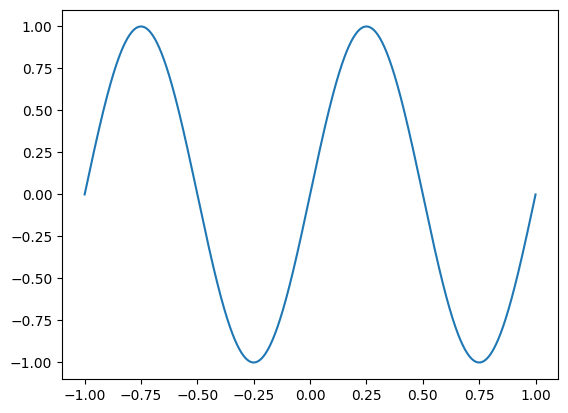

In [19]:
x = np.linspace(-1, 1, slot_count)
y = np.sin(2* np.pi*x)

import matplotlib.pyplot as plt
plt.plot(x, y)
plt.show()

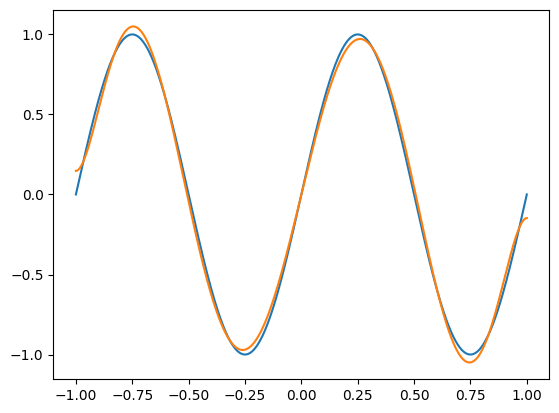

In [20]:
degree = 7 # 적절한 degree, 정밀도와 차수 사이의 적당한 부분을 찾는 게 중요
coefficients = np.polyfit(x, y, degree)

# ypoly = np.polyval(coefficients, x)

ypoly = np.zeros(slot_count)
coefficients_reverse = coefficients[::-1]

xpos = [1, x]
for i in range(2, degree+1):
    i0 = i//2
    i1 = i - i0
    tmp = np.multiply(xpos[i0], xpos[i1])
    xpos.append(tmp)

for i in range(degree+1):
    tmp  = np.multiply(coefficients_reverse[i], xpos[i])
    ypoly = np.add(ypoly, tmp)

# horner's method 
# for coeff in coefficients:
#     ypoly = ypoly * x + coeff

plt.plot(x, y)
plt.plot(x, ypoly)
plt.show()

In [21]:
ctx = engine.encorypt(x, pk)
ct_pow_list = [1, ctx]

for i in range(2, degree+1):
    i0 = i//2
    i1 = i - i0
    ctxi = engine.mult(ct_pow_list[i0], ct_pow_list[i1], rlk)
    ct_pow_list.append(ctxi)

In [22]:
coefficients_reverse = coefficients[::-1]
# ctpoly = engine.mult_plain(ct_pow_list[0], coefficients_reverse[0])
# ctpoly = engine.encorypt(, pk)


coeff_enc = engine.encorypt(coefficients_reverse[0], pk)
ctpoly = engine.mult(ct_pow_list[0], coeff_enc, rlk)

for i in range(1, degree+1):
    # (a) 평문 -> 암호문
    coeff_enc = engine.encorypt(coefficients_reverse[i], pk)
    # (b) ct_pow_list[i] (ciphertext) 와 coeff_enc (ciphertext) 곱
    tmp = engine.mult(ct_pow_list[i], coeff_enc, rlk)
    # (c) 누적합
    ctpoly = engine.add(ctpoly, tmp)



/home/user1/.cache/pypoetry/virtualenvs/liberate-fhe-0CiW_M-i-py3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/user1/.cache/pypoetry/virtualenvs/liberate-fhe-0CiW_M-i-py3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


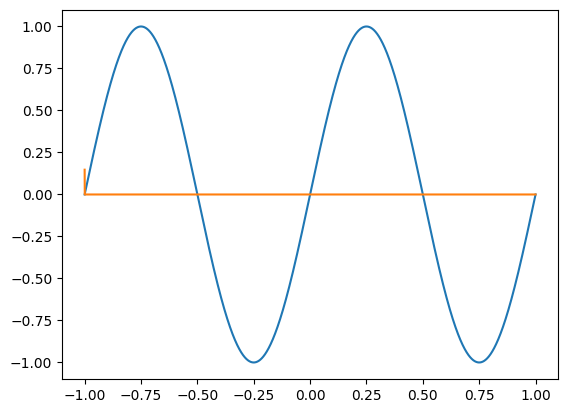

In [23]:
ptpoly = engine.decrode(ctpoly, sk)

plt.plot(x, y)
plt.plot(x, ptpoly)
plt.show()

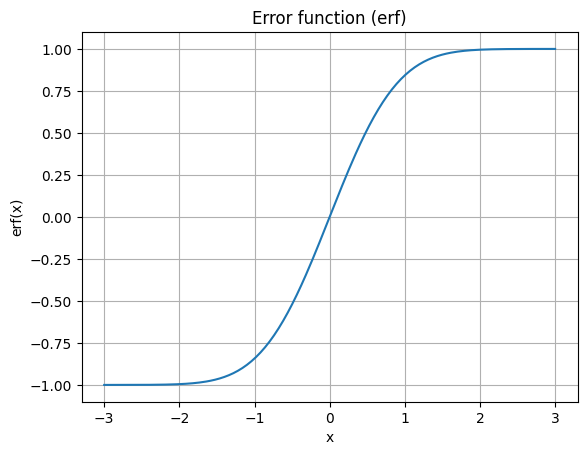

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import math

# x 범위 설정
x = np.linspace(-3, 3, 200)
# erf(x) 계산
y = [math.erf(xi) for xi in x]

plt.plot(x, y)
plt.title("Error function (erf)")
plt.xlabel("x")
plt.ylabel("erf(x)")
plt.grid(True)
plt.show()
